In [1]:
# Transforming discrete baryonic mass distributions to EG distributions

#!/usr/bin/python

# Import the necessary libraries
import numpy as np
import os

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import LambdaCDM
import astropy.io.fits as pyfits

import modules_EG as utils

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import gridspec
from matplotlib import rc, rcParams

%matplotlib notebook
#plt.rcParams['figure.dpi'] = 150

import scipy.constants as const
from scipy.integrate import cumtrapz, trapz, quad, dblquad
from scipy.constants import codata
D = codata.physical_constants

import astropy.units as u
import astropy.constants as const

pi = np.pi
inf = np.inf

# Make use of TeX
rc('text',usetex=True)

# Change all fonts to 'Computer Modern'
rc('font',**{'family':'serif','serif':['Computer Modern']})

In [2]:
# Constants
G = const.G.to('pc3 / (M_sun s2)').value
c = const.c.to('pc/s').value
#G = const.G.to('m3 / (kg s2)').value
#c = const.c.to('m/s').value

H0 = 100 * (u.km/u.s)/u.Mpc
H0 = H0.to('s-1').value

pc_to_m = 3.08567758e16

# Creating the spherical distance bins
nrbins = 100
rmin = 0.03 # in Mpc
rmax = 3. # in Mpc

rbins = 10.**np.linspace(np.log10(rmin), np.log10(rmax), nrbins)
dr = np.diff(rbins)
rcenters = rbins[0:-1]+0.5*dr

rbins, dr, rcenters = [rbins*1e6, dr*1e6, rcenters*1e6] # Convert Mpc to pc

In [3]:
# Conversion from baryonic to apparent DM distribution 
def calc_Md(Mb_r, r):

    H = H0 #* np.sqrt(O_matter*(1+z)**3 + O_lambda)
    Cd = (c * H) / (G * 6)
    Md_r = (Cd * np.gradient(Mb_r * r, r))**0.5 * r
    gd_r = G * Md_r / r**2. * pc_to_m # in m/s^2
    
    return Md_r, gd_r

def gobs_verlinde(gbar):
    gobs = gbar + np.sqrt((c*H0)/6) * np.sqrt(gbar)
    return gobs

def gobs_mond(gbar, g0=1.2e-10):
    gobs = gbar / (1 - np.exp( -np.sqrt(gbar/g0) ))
    return gobs

In [4]:

# Mb_r = np.ones(len(rcenters)) # Point mass
rho_c = 1 #Msun/pc**3.

Mb_const = 4./3. * pi * rcenters**3. * rho_c
Mb_point = rho_c * 1e14

gb_const = G * Mb_const/rcenters**2. * pc_to_m # in m/s^2
gb_point = G * Mb_point/rcenters**2. * pc_to_m # in m/s^2


Md_const, gd_const = calc_Md(Mb_const, rcenters)
gtot_const = (gb_const + gd_const)

Md_point, gd_point = calc_Md(Mb_point, rcenters)
gtot_point = (gb_point + gd_point)



/Users/users/brouwer/.conda/envs/brouwer/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


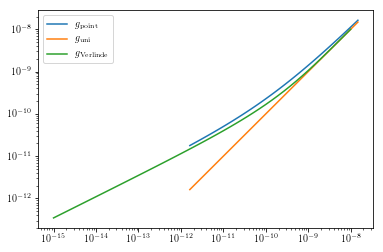

In [5]:
gb_uni = np.logspace(-15, -8, 50)
gtot_verlinde = gobs_verlinde(gb_uni)
gtot_mond = gobs_mond(gb_uni)

plt.plot(gb_point, gtot_point, label=r'$g_{\rm point}$')
plt.plot(gb_point, gb_point, label=r'$g_{\rm uni}$')
plt.plot(gb_uni, gtot_mond, label=r'$g_{\rm Verlinde}$')

#plt.plot(gb_uni, gb_uni, label=r'$g_{\rm uni}$')

plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-12, 1e-6)

plt.legend()


In [6]:
## Importing the satellite mass distributions

cat = 'mice'

# Define offset catalogue
if 'kids' in cat:
    offset = ''
else:
    offset = '-offsetZ'

# Full directory & name of the satellite distribution file
path_satcat = '/data/users/brouwer/Lensing_results/EG_results_Sep19/Plots'
satcatname = 'satellite_histogram_%s_isolated%s.fits'%(cat, offset)

satcatfile = '%s/%s'%(path_satcat, satcatname)
satcat = pyfits.open(satcatfile, memmap=True)[1].data

Msat_iso = satcat['Msat_iso']
Msat_all = satcat['Msat_all']

Mtot_iso = satcat['Mtot_iso']
Mtot_all = satcat['Mtot_all']

if 'kids' in cat:
    Msat = np.array([Msat_iso, Msat_all])
    Mtot = np.array([Mtot_iso, Mtot_all])
    masknames = ['Isolated', 'All galaxies']
else:
    Msat_isoff = satcat['Msat_isoff']
    Mtot_isoff = satcat['Mtot_isoff']
    
    Msat = np.array([Msat_iso, Msat_isoff, Msat_all])
    Mtot = np.array([Mtot_iso, Mtot_isoff, Mtot_all])
    masknames = ['Isolated', 'Isolated, offset', 'All galaxies']


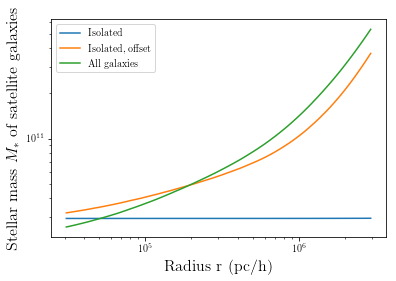

In [8]:

for m in range(len(masknames)):

    plt.plot(rcenters, Mtot[m], label=masknames[m])

xlabel = r'Radius r (pc/h)'
ylabel = r'Stellar mass $M_*$ of satellite galaxies'
plt.xlabel(xlabel, fontsize=16)
plt.ylabel(ylabel, fontsize=16)
    
plt.xscale('log')
plt.yscale('log')

plt.legend()


In [9]:
# Isolated galaxies
Mb_iso = Mtot_iso
gb_iso = G * Mb_iso/rcenters**2. * pc_to_m

Md_iso, gd_iso = calc_Md(Mb_iso, rcenters)
gtot_iso = (gb_iso + gd_iso)

# All galaxies
Mb_all = Mtot_all
gb_all = G * Mb_all/rcenters**2. * pc_to_m

Md_all, gd_all = calc_Md(Mb_all, rcenters)
gtot_all = (gb_all + gd_all)

if 'kids' not in cat:
    # Offset isolated galaxies
    Mb_isoff = Mtot_isoff
    gb_isoff = G * Mb_isoff/rcenters**2. * pc_to_m

    Md_isoff, gd_isoff = calc_Md(Mb_isoff, rcenters)
    gtot_isoff = (gb_isoff + gd_isoff)

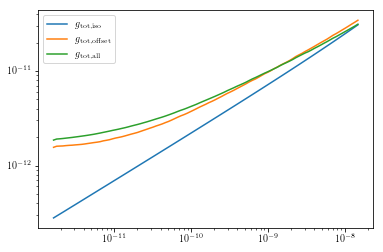

<Figure size 432x288 with 0 Axes>

In [10]:
plt.plot(gb_point, gtot_iso, label=r'$g_{\rm tot, iso}$')
plt.plot(gb_point, gtot_isoff, label=r'$g_{\rm tot, offset}$')
plt.plot(gb_point, gtot_all, label=r'$g_{\rm tot, all}$')

#plt.plot(gb_satiso, gb_satiso, label=r'$g_{\rm b, iso}$')
#plt.plot(gb_satisoff, gb_satisoff, label=r'$g_{\rm b, offset}$')

#plt.plot(gb_const, gtot_const, label=r'$g_{\rm const}$')
#plt.plot(gb_point, gtot_point, label=r'$g_{\rm point}$')

plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-12, 1e-6)

plt.legend()

plt.show()
plt.clf()